# Topic Modelling The Legend of Zelda: Tears of the Kingdom Reviews

In this notebook I'm going to use a Latent Dirichlet Allocation(LDA) model to identify the topics in user reviews for The Legend of Zelda: Tears of the Kingdom. We can use LDA in an exploratory way to determine which aspects of the game that players responded to negatively and positively. Therefore acknowledging areas for improvement in the future. 

I'll be using MALLET's (https://mimno.github.io/Mallet/) LDA Model, using little_mallet_wrapper (https://github.com/maria-antoniak/little-mallet-wrapper) for python implementation.

In [1]:
import re
import pandas as pd

# Gensim
import gensim
from gensim.models import CoherenceModel

# spacy for lemmatization/stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Import necessary libraries
import nltk
from wordcloud import WordCloud
from langdetect import detect
import string

#### Instantiating Review Data
I'll need to create dataframes with the review data and create new columns categorising each review into three different sentiments based on their score.
This follows the same standards seen on metacritic for scoring and allocated sentiments. 

In [4]:
#instantiate dataframe from data:

totk_reviews = pd.read_csv('totk_metacrit_user_reviews.csv')

#### Assign sentiments to scores based on metacritic designations

In [5]:
positive_scores= [10,9,8]
mixed_scores   = [5,6,7]
negative_scores= [0,1,2,3,4] 

totk_reviews['review_sentiment'] = pd.Series(np.select(
                                    [totk_reviews.score.isin(positive_scores),
                                     totk_reviews.score.isin(mixed_scores),
                                     totk_reviews.score.isin(negative_scores)],
                                     ['positive','mixed','negative']))


<Axes: xlabel='review_sentiment'>

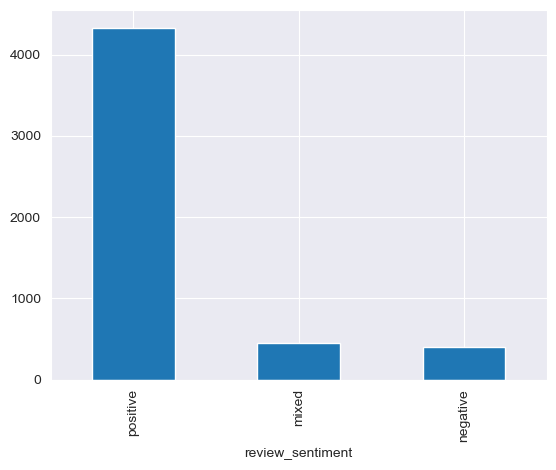

In [6]:
#Check the number of pos, neg and mixed written reviews.
totk_reviews.review_sentiment.value_counts().plot.bar()

There are about 5 times more positive reviews than negative+mixed reviews. I'll run a model for negative and mied reviews as well. As mixed reviews are likely to bring up similar complaints found in negative reviews.

#### Text Preprocessing:

I want to pre-process the review text before running the topic model.

This will involve:
- lower casing all text
- detecting english language reviews
- remove punctuation
- remove stopwords and any irrelevant frequently occuring words.
- lemmatizing words 
- remove any reviews that do not contain any alphabetic symbols
- Detect and Translate any non english reviews
- drop any duplicate reviews
- removing any reviews that are just digits

# ----------------------------------

First I'll create a list of stopwords using nltks built in stopwords aswell as adding a few words that are likely to repeat themselve throughout the review but wouldn't be useful for our topic model. 


#### Removing Duplicate Reviews
It's possible and very certain that within the gaming community there will be users who create multiple accounts to give the same exact review.
So I will remove duplicates.

In [7]:
totk_reviews = totk_reviews.drop_duplicates(subset=['review_text'])

#### Stopwords:
I'll use the stopwords from the nltk library and add a few words and strings I suspect will appear in multiple reviews but won't be useful.

In [8]:
nltk_stop_words = nltk.corpus.stopwords.words('english')

stop_words =  list(STOP_WORDS)
stop_words.extend(['game','legend','zelda','tears','kingdom','hyrule','totk','ztotk','wind','waker','skyward','sword','minecraft',
                   'botw','breath','wild','skyrim']) ### these are common words that appear in almost all reviews 

for word in nltk_stop_words:
    if word in stop_words: 
        continue
    else: stop_words.append(word)

In [9]:
# Text PreProcessing functions

#Removing punctuation

def remove_punc(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    return re.sub (r'[^\w\s]', ' ', text)

#remove extraspaces
def remove_extraspace(text):
    return re.sub(r'\s+', ' ', text)

#remove digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

#lowercase text
def lowercase_text(text):
    return text.lower()

#remove words from a list e.g. stopwords

def remove_wordlist(text,wordlist):
    for word in wordlist:
        if word in text.split():
            text = re.sub(r'\b{}\b'.format(word),'', text)
    return text
    
#removes escape r from any text
def remove_r(text):
    return text.replace('\r',' ')


def cleanup_text(text):
    text = lowercase_text(text)
    text = remove_punc(text)
    text = remove_digits(text)
    text = remove_wordlist(text, stop_words)
    text = remove_extraspace(text)
    text = remove_r(text)
    return text

In [10]:

def languagedetection(x):
    if  x == '' or x== ' ':
        return np.NaN
    
        #If the review_text value isan empty string, the function will return a nan value.
        
    else:
        result = detect(x)
        return  result


In [11]:
#import deep_translator to translate any non-english text.
from deep_translator import (GoogleTranslator,
                             PonsTranslator,
                             LingueeTranslator,
                             MyMemoryTranslator,
                             YandexTranslator,
                             single_detection,
                             batch_detection)

#### Cleaning Up Text
First we'll cleanup the text by removing punctuation and digits

In [12]:
totk_reviews['cleaned_text'] = totk_reviews.review_text.apply(lambda x: cleanup_text(x))

#### Language Detection and Translation
I'll assign a new column in the dataframe to be the review language found by applying the language detect function above to the review_text column.
After we'll use the Google Translator method to translate all non_english reviews.

In [13]:
import time
def translate(x):
    time.sleep(0.1)
    return GoogleTranslator(source='auto', target= 'en').translate(text=x)

In [14]:
totk_reviews['review_language'] = totk_reviews.cleaned_text.apply(lambda x: languagedetection(x))

In [15]:
#create 2 DataFrames: one with english reviews and the other with non-english reviews
non_english_reviews = totk_reviews[totk_reviews['review_language']!='en']
en_totk_reviews = totk_reviews[totk_reviews['review_language']=='en']

In [16]:
#Use the google translate module to translate all non-english text
non_english_reviews['review_text'] = non_english_reviews.loc[slice(None),'review_text'].apply(lambda x : translate(x))

non_english_reviews['cleaned_text'] = non_english_reviews.review_text.apply(lambda x: cleanup_text(x))


C:\Users\User\AppData\Local\Temp\ipykernel_12944\3635759664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_english_reviews['review_text'] = non_english_reviews.loc[slice(None),'review_text'].apply(lambda x : translate(x))
C:\Users\User\AppData\Local\Temp\ipykernel_12944\3635759664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_english_reviews['cleaned_text'] = non_english_reviews.review_text.apply(lambda x: cleanup_text(x))


In [17]:
#combine the english reviews with now translated non_english reviews

full_translated_reviews = pd.concat([non_english_reviews, en_totk_reviews],axis=0)
full_translated_reviews.review_sentiment.value_counts()

review_sentiment
positive    4318
mixed        450
negative     402
Name: count, dtype: int64

Now that we have a dataframe full of english language reviews and we've verified that we still have the same amount as before we can go ahead and cleanup the text with the cleanuptext function.

#### Lemmatizing the words in each review.
This can help remove plurailty and redundant conjugations in text.

First we need to tokenize all of the text and then lemmatize them. Finally we join them back together again to produce a cleaned up lemmatized sentence. 

I'll keep the lemmatized data in a separate column for comparisons sake.

In [18]:
sp = spacy.load('en_core_web_sm')
def lemmatize_words(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
 text = sp(text)
 lemmed_string =''
 for word in text:
     if word.pos_ in allowed_postags:
         if word.lemma_ == '-PRON-' or word.lemma_ in stop_words: 
    # skip words that are not in allowed postags or becomes a stopword when lemmatized 
             continue 
         else: lemmed_string = lemmed_string+' '+word.lemma_
 return lemmed_string.lstrip()


In [19]:
#Create a column with lemmatized versions of the reviews
full_translated_reviews['lemmatized_reviews'] = (full_translated_reviews['cleaned_text']
                                                 .apply(lambda x:lemmatize_words(x, allowed_postags=['NOUN', 'VERB']))
                                                )




#### Removing Rare Words
By removing rare words from the corpus we can improve the model by ensuring no rare words are fed into it. Ensuring only the more relevant terms are informing it.

In [20]:
### list all words that appear in less than 4 documents, and remove them from the reviews 
from collections import Counter

word_frequency = Counter()

for text in full_translated_reviews.cleaned_text:
    text = text.split()
    word_frequency.update(set(text)) 

rare_words = []

for key, value in word_frequency.items():
    if value < 4:
        rare_words.append(key)

In [21]:
full_translated_reviews['cleaned_text_nonrare'] = full_translated_reviews['cleaned_text'].apply(lambda x:remove_wordlist(x,rare_words)) 

In [22]:
word_frequency = Counter()

for text in full_translated_reviews.lemmatized_reviews:
    text = text.split()
    word_frequency.update(set(text)) 

rare_words = []

for key, value in word_frequency.items():
    if value < 4:
        rare_words.append(key)

In [23]:
full_translated_reviews['lemmatized_reviews_nonrare'] = full_translated_reviews['lemmatized_reviews'].apply(lambda x:remove_wordlist(x,rare_words))

## Removing uneccessary words:
There will be some words appear frequently but wouldn't help us other than to reflect the sentiment of the reviewer, which we already know. So by generating a list of the top 50 words appearing in the reviews for each sentiment we can take a look and see what words we can remove. 

In [25]:
#create a series of the lemmatized negative review text
lemmed_negative_words = full_translated_reviews[full_translated_reviews['review_sentiment']=='negative'].lemmatized_reviews_nonrare
lemmed_negmixed_words = full_translated_reviews[full_translated_reviews['review_sentiment']!='positive'].lemmatized_reviews_nonrare
lemmed_positive_words = full_translated_reviews[full_translated_reviews['review_sentiment']=='positive'].lemmatized_reviews_nonrare

topx_negative = pd.Series((' '.join(rev for rev in lemmed_negative_words)).split()).value_counts()[:75]
topx_negmix = pd.Series((' '.join(rev for rev in lemmed_negmixed_words)).split()).value_counts()[:75]
topx_positive = pd.Series((' '.join(rev for rev in lemmed_positive_words)).split()).value_counts()[:75]

print('   Negative Words' + '\n' ,topx_negative.index.values, '\n')
print('   Negative/Mixed Words' + '\n' ,topx_negmix.index.values, '\n')
print('   Positive Words' + '\n' ,topx_positive.index.values)

   Negative Words
 ['feel' 'play' 'time' 'story' 'world' 'map' 'weapon' 'mechanic' 'nintendo'
 'thing' 'year' 'find' 'way' 'shrine' 'graphic' 'dungeon' 'want' 'fun'
 'puzzle' 'hour' 'gameplay' 'look' 'break' 'character' 'people' 'lot'
 'build' 'need' 'dlc' 'item' 'think' 'fan' 'system' 'switch' 'experience'
 'bore' 'price' 'sky' 'use' 'combat' 'boss' 'run' 'quest' 'add' 'enemy'
 'content' 'try' 'building' 'change' 'fps' 'know' 'island' 'fight'
 'sequel' 'title' 'point' 'end' 'start' 'depth' 'power' 'player' 'come'
 'design' 'work' 'lack' 'waste' 'copy' 'problem' 'place' 'review'
 'ability' 'spend' 'performance' 'stuff' 'quality'] 

   Negative/Mixed Words
 ['feel' 'story' 'time' 'play' 'world' 'weapon' 'thing' 'mechanic' 'map'
 'way' 'find' 'dungeon' 'hour' 'fun' 'shrine' 'year' 'nintendo' 'lot'
 'gameplay' 'puzzle' 'want' 'sky' 'look' 'think' 'enemy' 'graphic' 'add'
 'build' 'need' 'quest' 'experience' 'character' 'combat' 'system' 'boss'
 'explore' 'island' 'use' 'people' 'ability' '

#### Words to Remove
From the lists we can remove the following: \
find, look, need, use, run, add, try, come, title, lack, area, work, enjoy, stuff, start, improve, change, recommend, play, thing, know, player, need, fan, want, stuff, love, goty, aspect, bit, drop, video, way, think, year


#### Removing the words
(PLUS A FEW OTHERS I CAN THINK OF)

In [45]:
recurring_words = ['play','want','makes','think','people','sequel','switch','lot','feels','feel','things','thing','fell','hours','way',
                  'totk','nintendo','games','game','breath','wild','new','like','botw','ztotk','aaa','triple a','company',
                   'triplea','skyward','sword','etc','wind','waker','link','minecraft','reviews','review','skyrim','good','great',
                   'know','amazing','best','better','fun','thing','masterpiece','boring','bore', 'find','look','need','needs','uses','use',
                    'run','running','add','try','come','title','lack','area','work','enjoy','stuff','start','improve','change','recommend','years',
                   'player','fan','love','goty','video','way','aspect','bit','drop','franchise','favourite','favorite','perfect','release',
                  'rate','incredible','year','beautiful','abolutely','wait','simply']
full_translated_reviews['cleaned_text_nonrare']=full_translated_reviews.cleaned_text_nonrare.apply(lambda x : " ".join(word for word in x.split() if word not in recurring_words))


In [46]:
full_translated_reviews['lemmatized_reviews_nonrare'] = full_translated_reviews.cleaned_text_nonrare.apply(lambda x: lemmatize_words(x))

In [47]:
full_translated_reviews['lemmatized_reviews_nonrare']=full_translated_reviews.lemmatized_reviews_nonrare.apply(lambda x : " ".join(word for word in x.split() if word not in recurring_words))

#### Saving a copy of the updated dataframe for future use:


In [48]:
full_translated_reviews.to_csv('cleaned_totk_reviews.csv',index=False)

# LDA MODEL WITH MALLET
I'll use litte_mallet_wrapper, a wrapper that alows implementation of MALLETS LDA from within python.

In [30]:
import little_mallet_wrapper as lmw
from pathlib import Path


In [31]:
from gensim import models

### Creating Models for Negative, Positive and Nega/Mixed Reviews.
 First we will create our datasets for positive, negative and neg/mixed reviews. The LDA model only requires the documents in the corpus in the form of an array. However to calculate coherence scores, so we can determine which number of topics creates the est model we also require a tokenized version of the data to form the dictionary. 

 We will also create equivalent datasets using the lemmatized data.

#### DATA WITH CLEANED UP TEXT

In [49]:
data_neg =    ( full_translated_reviews[full_translated_reviews['review_sentiment']=='negative']
                                .cleaned_text_nonrare
                                .values.tolist()
              )


data_neg_tok =( full_translated_reviews[full_translated_reviews['review_sentiment']=='negative']
                                .cleaned_text_nonrare
                                .apply(lambda x: x.split()).tolist()
              )

data_pos =    ( full_translated_reviews[full_translated_reviews['review_sentiment']=='positive']
                                .cleaned_text_nonrare
                                .values.tolist()
              )


data_pos_tok =( full_translated_reviews[full_translated_reviews['review_sentiment']=='positive']
                                .cleaned_text_nonrare
                                .apply(lambda x: x.split()).tolist()
              )


data_negmix =    ( full_translated_reviews[full_translated_reviews['review_sentiment']!='positive']
                                .cleaned_text_nonrare
                                .values.tolist()
              )


data_negmix_tok =( full_translated_reviews[full_translated_reviews['review_sentiment']!='positive']
                                .cleaned_text_nonrare
                                .apply(lambda x: x.split()).tolist()
              )

#### DATA WITH CLEANED UP LEMMATIZED TEXT

In [50]:
lem_data_neg =    ( full_translated_reviews[full_translated_reviews['review_sentiment']=='negative']
                                .lemmatized_reviews_nonrare
                                .values.tolist()
              )


lem_data_neg_tok =( full_translated_reviews[full_translated_reviews['review_sentiment']=='negative']
                                .lemmatized_reviews_nonrare
                                .apply(lambda x: x.split()).tolist()
              )

lem_data_pos =    ( full_translated_reviews[full_translated_reviews['review_sentiment']=='positive']
                                .lemmatized_reviews_nonrare
                                .values.tolist()
              )


lem_data_pos_tok =( full_translated_reviews[full_translated_reviews['review_sentiment']=='positive']
                                .lemmatized_reviews_nonrare
                                .apply(lambda x: x.split()).tolist()
              )


lem_data_negmix =    ( full_translated_reviews[full_translated_reviews['review_sentiment']!='positive']
                                .lemmatized_reviews_nonrare
                                .values.tolist()
              )


lem_data_negmix_tok =( full_translated_reviews[full_translated_reviews['review_sentiment']!='positive']
                                .lemmatized_reviews_nonrare
                                .apply(lambda x: x.split()).tolist()
              )

In [34]:
path_to_mallet = "C:/Mallet/bin/mallet.bat"

In [35]:
#set desired output directory
output_directory_path = "/Users/User/Documents/PythonScripts/EDApractice/totk_lmw_prac" # CHANGE THIS TO YOUR OUTPUT DIRECTORY

Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = output_directory_path + '/training.txt'
path_to_formatted_training_data = output_directory_path + '/mallet.training'
#path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
#path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
#path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
#path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
#path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'

In [36]:
def ldatopicmodel(corpus, training_data, text, id2word,start=2,limit=7,step=1):
    
    model_num  = []
    t_keys     = []
    coherence_scores = []
  
    lmw.import_data(path_to_mallet,
                    path_to_training_data,
                    path_to_formatted_training_data,
                    training_data
                    )
    
    for num in range(start,limit,step):

        model_num.append(num)
        num_topics = num

        path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
        path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
        path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
        path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
        path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'
                
        lmw.train_topic_model(path_to_mallet,
                              path_to_formatted_training_data,
                              path_to_model,
                              path_to_topic_keys,
                              path_to_topic_distributions,
                              path_to_word_weights,
                              path_to_diagnostics,
                              num_topics)
    
        
        topic_keys = lmw.load_topic_keys(path_to_topic_keys)
        t_keys.append(topic_keys)
        
        cm = CoherenceModel(
        topics=topic_keys,
        texts=text,
        corpus=corpus,
        dictionary=id2word,
        coherence='c_v')
    
        coherence_scores.append(cm.get_coherence())
    return coherence_scores, model_num, t_keys

## Positive Review Topics

In [51]:
#id2word = corpora.Dictionary(data_pos_tok)
#corpus = [id2word.doc2bow(text) for text in data_pos_tok]
#training_data = data_pos
#text = data_pos_tok
#pos_cm_score, pos_model_numbers, pos_t_keys = ldatopicmodel(corpus, training_data, text, id2word, start=3,limit=7,step=1)

id2word = corpora.Dictionary(lem_data_pos_tok)
corpus = [id2word.doc2bow(text) for text in lem_data_pos_tok]
training_data = lem_data_pos
text = lem_data_pos_tok
lem_pos_cm_score, lem_pos_model_numbers, lem_pos_t_keys = ldatopicmodel(corpus, training_data, text, id2word, start=3,limit=7,step=1)

Importing data...
Complete
Training topic model...
Complete
Training topic model...
Complete
Training topic model...
Complete
Training topic model...
Complete


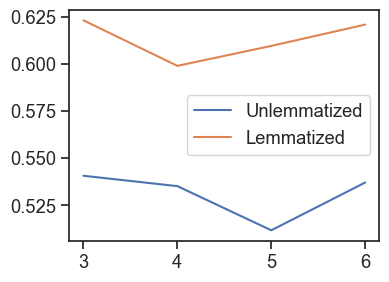

In [52]:
plt.figure(figsize=(4,3))
plt.plot(pos_model_numbers, pos_cm_score,label = 'Unlemmatized')
plt.plot(lem_pos_model_numbers, lem_pos_cm_score,label='Lemmatized')
plt.legend()


### Negative Reviews Topic Models

In [59]:
#id2word = corpora.Dictionary(data_neg_tok)
#corpus = [id2word.doc2bow(text) for text in data_neg_tok]
#training_data = data_neg
#text = data_neg_tok
#neg_cm_score, neg_model_numbers, neg_t_keys = ldatopicmodel(corpus, training_data, text, id2word, start=3,limit=7,step=1)

id2word = corpora.Dictionary(lem_data_neg_tok)
corpus = [id2word.doc2bow(text) for text in lem_data_neg_tok]
training_data = lem_data_neg
text = lem_data_neg_tok
lem_neg_cm_score, lem_neg_model_numbers, lem_neg_t_keys = ldatopicmodel(corpus, training_data, text, id2word, start=3,limit=7,step=1)



Importing data...
Complete
Training topic model...
Complete
Training topic model...
Complete
Training topic model...
Complete
Training topic model...
Complete


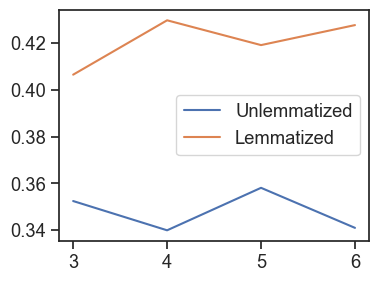

In [60]:
plt.figure(figsize=(4,3))
plt.plot(neg_model_numbers, neg_cm_score,label = 'Unlemmatized')
plt.plot(lem_neg_model_numbers, lem_neg_cm_score,label='Lemmatized')
plt.legend()


### NEGATIVE/MIXED REVIEW TOPIC MODEL

In [55]:
#id2word = corpora.Dictionary(data_negmix_tok)
#corpus = [id2word.doc2bow(text) for text in data_negmix_tok]
#training_data = data_negmix
#text = data_negmix_tok
#negmix_cm_score, negmix_model_numbers, negmix_t_keys = ldatopicmodel(corpus, training_data, text, id2word, start=3,limit=7,step=1)


id2word = corpora.Dictionary(lem_data_negmix_tok)
corpus = [id2word.doc2bow(text) for text in lem_data_negmix_tok]
training_data = lem_data_negmix
text = lem_data_negmix_tok
lem_negmix_cm_score, lem_negmix_model_numbers, lem_negmix_t_keys = ldatopicmodel(corpus, training_data, text, id2word, start=3,limit=7,step=1)



Importing data...
Complete
Training topic model...
Complete
Training topic model...
Complete
Training topic model...
Complete
Training topic model...
Complete


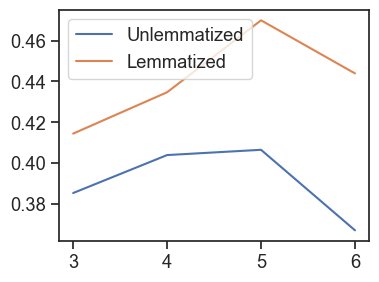

In [56]:
plt.figure(figsize=(4,3))
plt.plot(negmix_model_numbers, negmix_cm_score,label = 'Unlemmatized') 
plt.plot(lem_negmix_model_numbers, lem_negmix_cm_score,label = 'Lemmatized') 
plt.legend()

# Topic Summary 
I've chosen the topic models with greater coherence scores. In some cases there are a few words that appear in more than one topic. I have tried to summarise these as best I can into 1 or two words based on the other words in the topic. Ultimately we can get a clear picture of what kind of things players discuss in their positive, negative or mixed reviews.



In [62]:
print('Positive Review Topics' + '\n')
for i, t in enumerate(lem_pos_t_keys[3]):
    print(i+1, '\t', ' '.join(t[:15]))

print('\n'+'Negative Review Topics' + '\n')
for i, t in enumerate(lem_neg_t_keys[1]):
    print(i+1, '\t', ' '.join(t[:15]))

print('\n'+'Negative/Mixed Review Topics' + '\n')
for i, t in enumerate(lem_negmix_t_keys[2]):
    print(i+1, '\t', ' '.join(t[:15]))

Positive Review Topics

1 	 graphic bad fps performance console issue problem score frame little fix hardware dlc time point
2 	 time year experience absolutely wait finish life long day end stop spend buy gaming worth
3 	 world story mechanic open gameplay beautiful simply explore freedom time predecessor previous map creativity history
4 	 gameplay experience world adventure character challenge series design narrative truly set create captivate engage moment
5 	 weapon fuse time hand ability puzzle item combat system enemy solve build allow world break
6 	 map story sky explore dungeon boss island world ability depth quest underground enemy different main

Negative Review Topics

1 	 weapon puzzle item build shrine break time dungeon fight enemy mechanic combat content fuse building
2 	 map story sky repetitive time character shrine depth pretty interesting main island quest boss place
3 	 bad story world time mechanic graphic previous gameplay experience open dlc long old problem sy

# Topic Summary and Reflection
I'll summarise the topics into one or two words aswell as inspect some reviews to flesh out the details. 

#### Positive
1. Technical Performance \
   The framerate and graphical quality in relatio to the dated hardware is discussed despite coming from positive reviews.

2. Worth the wait\
   The wait for the game was worth it 
3. World Exploration\
   World exploration and its freedom is praised.
4. Gameplay Experience \
   The overall expeirence, from gameplay and narrative was engaging
5. New Abilities\
   Discussion on the major abilities the player character has.
6. Expanded Map Elements \
   Positive recpetion toward the sky islands adn depths introduced in the new game
   

#### Negative

1. New Abilities and Puzzle Solving \
   Weapons and puzzle mechanics aare discussed with reference to shrines and dungeons.
   
2. Repetitive Map Elements \
   Sky Islands and the Depths, while interesting conceptually, were too repetitive.
   
3. Story and retread ideas \
   The game is compared to "dlc" - downloadable content indicating that retread ideas and map was dissapointing for some players.
   
4. Technical Performance \
   Graphics Frame rate left players dissapointed given the high price point of the game.

#### Negative/Mixed
1. World Exploration 
      
2. Gameplay Experience 
3. Retread Ideas
4. Technical Performance \
   Framerate and graphical quality
5. Combat/Weapon Systems \
   Players found the fuse mechanic annoying especially with archery as well as the returning weapon durability system. 


#### Conclusion
The LDA mallet has served well at giving us a overall look at what players thought was good and bad about Tears of the Kingdom. Some further inspection of reviews indepently is required to flesh out the topics but if someone has played the game (or perhaps worked on it) they could easily understand what parts of the game are being discussed based on these topics. That is true despitethe cases of the more vague topics appearing that seem to more generalise the gameplay experience as a whole rather than individual aspects. \
The notable standouts for future improvement are obviously the games technical performance. Though this could serve also as a complaint about the now dated Switch console. However players do also view tears of the kingdom as "dlc" and being to reliant on assets and structure of the previous title of which it recycles a majority of map elements. And despite new map elements introduced there seems to be mixed opinion on it. One another notebale complaint concerns weapon mechanics most likely the implementation (not the concept) of the fuse mechanic as well as weapon durability.